## Criteria

Требования к нереляционным БД
- нереляционная БД
- красивая структура БД
- интерфейс позволяет класть, доставать, удалять данные (проводить операции CRUD - Create, Read, Update, Delete)
- два действия помимо CRUD (сортировка, группировка, агрегация, ...)
- нахождение путей не только к соседним вершинам, операции с графами

# Let us read the network
### [About the network](http://tolstoy.online)

In [603]:
import matplotlib.pyplot as plt
import pandas as pd
import time

from neo4j import GraphDatabase
from neo4j.exceptions import CypherSyntaxError

In [143]:
wap = pd.read_csv('war_and_peace_network.csv', index_col='Id')
wap.head()

,Source,Target,Type,Label,timeset,Weight
Id,,,,,,
5509,Yakov_Alpatych,Nikolai_Rostov,Directed,NaN,NaN,5
5510,AndreyBolkonsky,Prince_Dolgorukov,Directed,NaN,NaN,11
5511,Nikolai_Rostov,Count_Ilya_Rostov,Directed,NaN,NaN,12
5512,приказный23_3_3_,полицеймейстер23_3_3_,Directed,NaN,NaN,2
6708,Prince_Nikolay_Bolkonsky,2,Directed,NaN,NaN,3


it seems like some columns are not informative

In [144]:
wap.Type.unique()

array(['Directed'], dtype=object)

In [145]:
wap.Label.unique()

array([nan])

In [146]:
wap.timeset.unique()

array([nan])

they are not, so we can drop them

In [147]:
wap = wap.drop(['Type', 'Label', 'timeset'], axis=1)
wap.head()

,Source,Target,Weight
Id,,,
5509,Yakov_Alpatych,Nikolai_Rostov,5
5510,AndreyBolkonsky,Prince_Dolgorukov,11
5511,Nikolai_Rostov,Count_Ilya_Rostov,12
5512,приказный23_3_3_,полицеймейстер23_3_3_,2
6708,Prince_Nikolay_Bolkonsky,2,3


# NEO4J

## Useful Links

#### intro
 - [about graph DBs](https://neo4j.com/developer/graph-database/)

#### cypher
- [online course](https://neo4j.com/graphacademy/online-training/introduction-to-neo4j/part-0/)
- [about cypher](https://neo4j.com/developer/cypher-query-language/)
- [quick help](https://neo4j.com/docs/2.0/cypher-refcard/)

#### python
- [driver example](https://neo4j.com/docs/api/python-driver/current/)
- [python manual](https://neo4j.com/docs/driver-manual/1.7/#driver-get-the-driver)



In [148]:
class HelloWorldExample(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def print_greeting(self, message):
        with self._driver.session() as session:
            greeting = session.write_transaction(self._create_and_return_greeting, message)
            print(greeting)

    @staticmethod
    def _create_and_return_greeting(tx, message):
        result = tx.run("CREATE (a:Greeting) "
                        "SET a.message = $message "
                        "RETURN a.message + ', from node ' + id(a)", message=message)
        return result.single()[0]

In [149]:
HWE = HelloWorldExample("bolt://localhost:7687",'neo4j', 'NEO4J')

In [150]:
HWE.print_greeting('IT WORKS OH MY GOD!!!111')

IT WORKS OH MY GOD!!!111, from node 0


In [220]:
class Driver(object):

    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

In [152]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=('neo4j', 'NEO4J'))

In [387]:
with driver.session() as session:
    result = session.run("CREATE (a:Person {name: 'Emma'}) -[k:knows]-> (b:Person {name: 'Emil'}) RETURN a, b, k")
    for el in result:
        print(el)

<Record a=<Node id=205 labels={'Person'} properties={'name': 'Emma'}> b=<Node id=206 labels={'Person'} properties={'name': 'Emil'}> k=<Relationship id=300 nodes=(<Node id=205 labels={'Person'} properties={'name': 'Emma'}>, <Node id=206 labels={'Person'} properties={'name': 'Emil'}>) type='knows' properties={}>>


In [376]:
with driver.session() as session:
    result = session.run('MATCH (n) RETURN (n)')
    for el in result:
        print(el)

<Record n=<Node id=0 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record n=<Node id=203 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=204 labels={'Person'} properties={'name': 'Emil'}>>
<Record n=<Node id=228 labels={'Person'} properties={'name': 'Johan'}>>
<Record n=<Node id=229 labels={'Person'} properties={'name': 'Henry'}>>
<Record n=<Node id=231 labels={'Person'} properties={'name': 'Mary', 'age': 99}>>
<Record n=<Node id=235 labels={'Person'} properties={'name': 'Johan', 'learn': 'surfing', 'from': 'Sweden'}>>
<Record n=<Node id=236 labels={'Person'} properties={'name': 'Ian', 'title': 'author', 'from': 'England'}>>
<Record n=<Node id=237 labels={'Person'} properties={'name': 'Rik', 'from': 'Belgium', 'pet': 'Orval'}>>
<Record n=<Node id=238 labels={'Person'} properties={'name': 'Allison', 'from': 'California', 'hobby': 'surfing'}>>
<Record n=<Node id=239 labels=set() properties={}>>
<Record n=<Node id=240 labels={'Person'} properties=

In [377]:
def execute(driver, command):
    """
    executes a ready formed CYPHER command
    
    :param driver: GraphDatabase.driver
    :param command: str, valid CYPHER command
    :return: neo4j.BoltStatementResult or None
    """
    with driver.session() as session:
        result = session.run(command)
    return result

## Syntax functions

In [242]:
def protect_properties(properties_dict):
    """
    creates a CYPHER properties string from a dict
    
    :param: dict, properties
    :return: str, CYPHER properties
    """
    properties_str = '{'
    for key, value in properties_dict.items():
        properties_str += str(key)+': '
        if type(value) == str:
            properties_str += f'"{value}", '
        elif type(value) == type(None):
            properties_str += 'null, '
        else:
            properties_str += f'{value}, '
    return properties_str.strip(', ') + '}'

In [378]:
protect_properties({ 'name': "Emil", 'from': "Sweden", 'klout': 99, 'HATE': None})

'{name: "Emil", from: "Sweden", klout: 99, HATE: null}'

In [247]:
def protect_vars(vars_iter):
    """
    merges a list of variables into a CYPHER commad string
    
    :param vars_iter: iterable of str, variable names
    :return: str, CYPHER commad string
    """
    if type(vars_iter) != str:
        ret_vars_str = ', '.join(vars_iter)
    else:
        ret_vars_str = vars_iter
    return ret_vars_str

In [379]:
protect_vars('(n)')

'(n)'

In [380]:
protect_vars(['n', 'r', 'em'])

'n, r, em'

### Nodes

In [156]:
# CREATE (ee:Person { name: "Emil", from: "Sweden", klout: 99 })
def node_obj(node_label, node_var=None, node_properties={}):
    """
    node string  
    
    :param node_label: str, label
    :param node_var: str, node variable name, optional, default None
    :param node_properties: dict with str keys, optional, default empty dict
    :return: str, node command part
    """
    if node_var:
        node_var_str = node_var + ':'
    else:
        node_var_str = ''
    if node_properties:
        node_properties_str = protect_properties(node_properties)
    else:
        node_properties_str = ''
    command = f'({node_var_str}{node_label} {node_properties_str})'
    return command

In [381]:
node_obj('Person', var, { 'name': 'Mary', 'age': 99 })

'(ee:Person {name: "Mary", age: 99})'

In [227]:
def show_all(driver):
    res = execute(driver, 'MATCH (n) RETURN n')
    for el in res:
        print(el)

In [233]:
def ddelete_all(driver):
    execute(driver, 'MATCH (n) DETACH DELETE n')

In [382]:
ddelete_all(driver)

In [388]:
with driver.session() as session:
    result = session.run("CREATE (a:Person {name: 'Emma'}) -[k:knows]-> (b:Person {name: 'Emil'}) RETURN a, b, k")
    for el in result:
        print(el)

<Record a=<Node id=216 labels={'Person'} properties={'name': 'Emma'}> b=<Node id=217 labels={'Person'} properties={'name': 'Emil'}> k=<Relationship id=317 nodes=(<Node id=216 labels={'Person'} properties={'name': 'Emma'}>, <Node id=217 labels={'Person'} properties={'name': 'Emil'}>) type='knows' properties={}>>


In [389]:
show_all(driver)

<Record n=<Node id=201 labels={'Person'} properties={'name': 'Mary', 'age': 99}>>
<Record n=<Node id=202 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record n=<Node id=205 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=206 labels={'Person'} properties={'name': 'Emil'}>>
<Record n=<Node id=216 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=217 labels={'Person'} properties={'name': 'Emil'}>>


In [390]:
var = 'Mary'
person_node_str = node_obj('Person', var, { 'name': 'Mary', 'age': 99 })
for el in execute(driver, f'CREATE {person_node_str} RETURN {var}'):
    print(el)

<Record Mary=<Node id=218 labels={'Person'} properties={'name': 'Mary', 'age': 99}>>


In [391]:
var = 'em'
person_node_str = node_obj('Person', var, { 'name': 'Emil', 'from': 'Sweden', 'klout': 99 })
for el in execute(driver, f'CREATE {person_node_str} RETURN {var}'):
    print(el)

<Record em=<Node id=219 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


In [392]:
show_all(driver)

<Record n=<Node id=201 labels={'Person'} properties={'name': 'Mary', 'age': 99}>>
<Record n=<Node id=202 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record n=<Node id=205 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=206 labels={'Person'} properties={'name': 'Emil'}>>
<Record n=<Node id=216 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=217 labels={'Person'} properties={'name': 'Emil'}>>
<Record n=<Node id=218 labels={'Person'} properties={'name': 'Mary', 'age': 99}>>
<Record n=<Node id=219 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


In [393]:
var = 'em'
person_node_str = node_obj('Person', var, { 'name': 'Emil', 'from': 'Sweden', 'klout': 99 })
for el in execute(driver, f'MATCH {person_node_str} RETURN {var}'):
    print(el)

<Record em=<Node id=202 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record em=<Node id=219 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


### Edges

In [489]:
# CREATE (ee)-[:KNOWS {rating: 5}]->(ir)
def edge_obj(from_node, to_node, edge_label, edge_var=None, edge_properties={}):
    """
    edge string  
    
    :param from_node: str, from node command part
    :param to_node: str, to node command part
    :param edge_label: str, label
    :param edge_var: str, edge variable name, optional, default None
    :param edge_properties: dict with str keys, optional, default empty dict
    :return: str, node command part
    """
    if edge_properties:
        edge_properties_str = protect_properties(edge_properties)
    else:
        edge_properties_str = ''
    if not edge_var:
        edge_var = ''
    command = f'{from_node}-[{edge_var}:{edge_label} {edge_properties_str}]->{to_node}'
    return command

In [394]:
edge_var = 'k'
know_edge_obj = edge_obj(person_node_str, f'({var})', 'KNOWS', edge_var, {'duration':'always'})
know_edge_obj

'(em:Person {name: "Emil", from: "Sweden", klout: 99})-[k:KNOWS {duration: "always"}]->(em)'

In [395]:
for el in execute(driver, f'CREATE {know_edge_obj} RETURN {protect_vars([edge_var, var])}'):
    print(el)

<Record k=<Relationship id=318 nodes=(<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>, <Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>) type='KNOWS' properties={'duration': 'always'}> em=<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


In [490]:
edge_var = 'k'
know_edge_obj = edge_obj(f'(n)', f'({var})', 'KNOWS', edge_var)
know_edge_obj

'(n)-[k:KNOWS ]->(ee)'

In [491]:
edge_var = 'k'
know_edge_obj = edge_obj(f'(n)', f'({var})', 'KNOWS')
know_edge_obj

'(n)-[:KNOWS ]->(ee)'

In [397]:
for el in execute(driver, f"""MATCH {know_edge_obj} RETURN {protect_vars([edge_var, var, 'n'])}"""):
    print(el)

<Record k=<Relationship id=318 nodes=(<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>, <Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>) type='KNOWS' properties={'duration': 'always'}> em=<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}> n=<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


### READ

#### CREATE

In [323]:
# CREATE (js:Person { name: "Johan", from: "Sweden", learn: "surfing" }),
# (ir:Person { name: "Ian", from: "England", title: "author" }),
# (rvb:Person { name: "Rik", from: "Belgium", pet: "Orval" }),
# (ally:Person { name: "Allison", from: "California", hobby: "surfing" }),
# (ee)-[:KNOWS {since: 2001}]->(js),(ee)-[:KNOWS {rating: 5}]->(ir),
# (js)-[:KNOWS]->(ir),(js)-[:KNOWS]->(rvb),
# (ir)-[:KNOWS]->(js),(ir)-[:KNOWS]->(ally),
# (rvb)-[:KNOWS]->(ally)
# RETURN rvb, ally

def CREATE(driver, statement, ret_vars=[]):
    """
    executes a CREATE CYPHER statement
    
    :param driver: GraphDatabase.driver
    :param statement: str, valid CYPHER object statement 
                      (including multiple objects and edges)
    :param ret_vars: str or list of str, variables to return, 
                     optional, default = []
    :return: neo4j.BoltStatementResult 
             or None (if ret_vars not specified)
    """
    DO = ''
    if ret_vars:
        DO = f'CREATE {statement} RETURN {protect_vars(ret_vars)}'
    else:
        DO = f'CREATE {statement}'
    return execute(driver, DO) 

In [398]:
var = 'em'
person_node_str = node_obj('Person', var, { 'name': 'Emil', 'from': 'Sweden', 'klout': 99 })
edge_var = 'k'
know_edge_obj = edge_obj(person_node_str, f'({var})', 'KNOWS', edge_var, {'duration':'always'})
for el in CREATE(driver, know_edge_obj, [edge_var, var]):
    print(el)

<Record k=<Relationship id=319 nodes=(<Node id=221 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>, <Node id=221 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>) type='KNOWS' properties={'duration': 'always'}> em=<Node id=221 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


In [458]:
statement = """ (js:Person { name: "Johan", from: "Sweden", learn: "surfing" }),
(ir:Person { name: "Ian", from: "England", title: "author" }),
(rvb:Person { name: "Rik", from: "Belgium", pet: "Orval" }),
(ally:Person { name: "Allison", from: "California", hobby: "surfing" }),
(ee)-[:KNOWS {since: 2001}]->(js),(ee)-[:KNOWS {rating: 5}]->(ir),
(js)-[:KNOWS]->(ir),(js)-[:KNOWS]->(rvb),
(ir)-[:KNOWS]->(js),(ir)-[:KNOWS]->(ally),
(rvb)-[:KNOWS]->(ally) """

ret_vars = ['rvb', 'ally', 'js', 'ir', 'ee']
for el in CREATE(driver, statement, ret_vars):
    print(el)

<Record rvb=<Node id=244 labels={'Person'} properties={'name': 'Rik', 'from': 'Belgium', 'pet': 'Orval'}> ally=<Node id=245 labels={'Person'} properties={'name': 'Allison', 'from': 'California', 'hobby': 'surfing'}> js=<Node id=230 labels={'Person'} properties={'name': 'Johan', 'learn': 'surfing', 'from': 'Sweden'}> ir=<Node id=243 labels={'Person'} properties={'name': 'Ian', 'title': 'author', 'from': 'England'}> ee=<Node id=246 labels=set() properties={}>>


#### MERGE

In [540]:
# MERGE (keanu:Person { name: 'Keanu Reeves' })
# ON CREATE SET keanu.created = timestamp()
# ON MATCH SET keanu.lastSeen = timestamp()
# RETURN keanu.name, keanu.created, keanu.lastSeen

def MERGE(driver, statement, on_create=None, on_match=None, ret_vars=[], return_str=False):
    """
    executes a MERGE CYPHER statement
    
    :param driver: GraphDatabase.driver
    :param statement: str, valid CYPHER object statement 
                      (including multiple objects and edges)
    :param on_create: str, valid CYPHER SET statement, 
                      optional, default None
    :param on_match: str, valid CYPHER SET statement, 
                     optional, default None
    :param ret_vars: str or list of str, variables to return, 
                     optional, default []
    :param return_str: bool, whether to return the command or to execute it,
                       optional, default False
    :return: neo4j.BoltStatementResult 
             if not ret_vars: None
             if return_str: str CYPHER MERGE command
    """
    DO = f'MERGE {statement}'
    if on_create:
        DO += f' ON CREATE {on_create}'
    if on_match:
        DO += f' ON MATCH {on_match}'
    if ret_vars:
        DO += f' RETURN {protect_vars(ret_vars)}'
    if return_str:
        return DO
    else:
        return execute(driver, DO) 

In [429]:
var_keanu = 'keanu'
keanu = node_obj('Person', var_keanu, { 'name': 'Keanu Reeves'})
on_create = 'SET keanu.created = timestamp()'
on_match = 'SET keanu.lastSeen = timestamp()'
ret_vars = ['keanu.name', 'keanu.created', 'keanu.lastSeen']

for el in MERGE(driver, keanu, on_create=on_create, on_match=on_match, ret_vars=ret_vars):
    print(el)

print('___')
time.sleep(10)
for el in MERGE(driver, keanu, on_create=on_create, on_match=on_match, ret_vars=ret_vars):
    print(el)

<Record keanu.name='Keanu Reeves' keanu.created=1584972006640 keanu.lastSeen=1584972744947>
___
<Record keanu.name='Keanu Reeves' keanu.created=1584972006640 keanu.lastSeen=1584972764956>


In [542]:
var_keanu = 'keanu'
keanu = node_obj('Person', var_keanu, { 'name': 'Keanu Reeves'})
on_create = 'SET keanu.created = timestamp()'
on_match = 'SET keanu.lastSeen = timestamp()'
ret_vars = ['keanu.name', 'keanu.created', 'keanu.lastSeen']
MERGE(driver, keanu, on_create=on_create, on_match=on_match, ret_vars=ret_vars, return_str=True)

'MERGE (keanu:Person {name: "Keanu Reeves"}) ON CREATE SET keanu.created = timestamp() ON MATCH SET keanu.lastSeen = timestamp() RETURN keanu.name, keanu.created, keanu.lastSeen'

### LOOK UP and CHANGE

#### CONDITIONS

MATCH (js:Person)-[:KNOWS]-()-[:KNOWS]-(surfer)<br>
**WHERE js.name = "Johan" AND surfer.hobby = "surfing"**<br>
RETURN DISTINCT surfer<br>

MATCH (director:Person)<br>
**WHERE director.name STARTS WITH 'Pet'**<br>
RETURN director.name<br>

MATCH (director:Person)<br>
**WHERE director.name ENDS WITH 'ter'**<br>
RETURN director.name<br>

#### MATCH

In [519]:
# MATCH (ee:Person) WHERE ee.name = "Emil" RETURN ee;

# MATCH (ee:Person)-[:KNOWS]-(friends)
# WHERE ee.name = "Emil" RETURN ee, friends

def MATCH(driver, statement, conditions, ret_vars=[], return_str=False):
    """
    executes a MATCH CYPHER statement
        or returns a MATCH CYPHER command
    
    :param driver: GraphDatabase.driver
    :param statement: str, valid CYPHER object statement 
                      (including multiple objects and edges)
    :param conditions: str, valid CYPHER conditions statement
    :param ret_vars: str or list of str, variables to DISTINCT return, 
                     optional, default []
    :param return_str: bool, whether to return the command or to execute it,
                       optional, default False
    :return: neo4j.BoltStatementResult 
             if not ret_vars: None
             if return_str: str CYPHER MATCH command
    """
    DO = f'MATCH {statement}'
    if conditions:
        DO += f' WHERE {conditions}'
    if return_str:
        return DO
    if ret_vars:
        DO += f' RETURN DISTINCT {protect_vars(ret_vars)}'
    return execute(driver, DO) 

In [521]:
var = 'ee'
for el in MATCH(driver, f'({var})', f'{var}.name = "Emil"', var):
    print(el)

In [337]:
var = 'ee'
MATCH(driver, f'({var})', f'{var}.name = "Emil"', var, return_str=True)

'MATCH (ee) WHERE ee.name = "Emil"'

In [338]:
execute(driver, "CREATE (js:Person {name: 'Johan'})-[:KNOWS]->(em:Person {name: 'Henry'})-[:KNOWS]->(surfer:Person {name: 'Paul', hobby: 'surfing'})")

In [339]:
# MATCH (js:Person)-[:KNOWS]-()-[:KNOWS]-(surfer)
# WHERE js.name = "Johan" AND surfer.hobby = "surfing"
# RETURN DISTINCT surfer

for el in MATCH(driver, '(js:Person)-[:KNOWS]-()-[:KNOWS]-(surfer)', 
                'js.name = "Johan" AND surfer.hobby = "surfing"', 'surfer'):
    print(el)

<Record surfer=<Node id=0 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record surfer=<Node id=263 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record surfer=<Node id=238 labels={'Person'} properties={'name': 'Allison', 'from': 'California', 'hobby': 'surfing'}>>


In [340]:
for el in MATCH(driver, '(js:Person)', 'js.name STARTS WITH "Em"', 'js'):
    print(el)

<Record js=<Node id=232 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=233 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=234 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=264 labels={'Person'} properties={'name': 'Emma'}>>
<Record js=<Node id=265 labels={'Person'} properties={'name': 'Emil'}>>


In [341]:
for el in MATCH(driver, '(js:Person)', 'js.name ENDS WITH "l"', 'js'):
    print(el)

<Record js=<Node id=0 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record js=<Node id=232 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=233 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=234 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record js=<Node id=263 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record js=<Node id=265 labels={'Person'} properties={'name': 'Emil'}>>


In [342]:
for el in MATCH(driver, '(js:Person)', 'js.name = "Emma" OR js.hobby = "surfing"', 'js'):
    print(el)

<Record js=<Node id=0 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record js=<Node id=238 labels={'Person'} properties={'name': 'Allison', 'from': 'California', 'hobby': 'surfing'}>>
<Record js=<Node id=263 labels={'Person'} properties={'name': 'Paul', 'hobby': 'surfing'}>>
<Record js=<Node id=264 labels={'Person'} properties={'name': 'Emma'}>>


#### SET

In [435]:
# MATCH (fan:Person)-[w:WATCHED]->(movie)
# WHERE fan.name = "Mikey"
# SET w.rating = 5

def SET(driver, match, properties, ret_vars=[], return_str=False):
    """
    executes a SET CYPHER command
        or returns a SET CYPHER command
    
    :param driver: GraphDatabase.driver
    :param match: str, valid CYPHER MATCH statement
    :param properties: str or list of str, valid CYPHER properties statement(s)
    :param ret_vars: str or list of str, variables to DISTINCT return, 
                     optional, default []
    :param return_str: bool, whether to return the command or to execute it,
                       optional, default False
    :return: neo4j.BoltStatementResult 
             if not ret_vars: None
             if return_str: str CYPHER SET command
    """
    if match:
        DO = match
    else:
        DO = ''
    properties = protect_vars(properties)
    DO += f'SET {properties}'
    if ret_vars:
        DO += f' RETURN {protect_vars(ret_vars)}'
    if return_str:
        return DO
    else:
        return execute(driver, DO)

In [436]:
SET(driver, None, 'w.rating = 5', return_str=True)

'SET w.rating = 5'

In [437]:
SET(driver, None, ['w.rating = 5', 'm.length = 32'], return_str=True)

'SET w.rating = 5, m.length = 32'

In [361]:
var = 'ee'
match = MATCH(driver, f'({var})', f'{var}.name = "Emma"', return_str=True)
properties = [f'{var}.age = 10', f'{var}.education = "primary school"']
for el in SET(driver, match, properties, var):
    print(el)

<Record ee=<Node id=264 labels={'Person'} properties={'name': 'Emma', 'age': 10, 'education': 'primary school'}>>


In [363]:
for el in MATCH(driver, f'({var})', f'{var}.name = "Emma"', var):
    print(el)

<Record ee=<Node id=264 labels={'Person'} properties={'name': 'Emma', 'age': 10, 'education': 'primary school'}>>


In [430]:
var_keanu = 'keanu'
keanu = node_obj('Person', var_keanu, { 'name': 'Keanu Reeves'})
on_create = SET(driver, None, 'keanu.created = timestamp()', return_str=True)
on_match = SET(driver, None, 'keanu.lastSeen = "now"', return_str=True)
ret_vars = ['keanu.name', 'keanu.created', 'keanu.lastSeen']

for el in MERGE(driver, keanu, on_create=on_create, on_match=on_match, ret_vars=ret_vars):
    print(el)

<Record keanu.name='Keanu Reeves' keanu.created=1584972006640 keanu.lastSeen='now'>


#### DELETE

In [365]:
# MATCH (n)-[r]-()
# WHERE n.name = 'Emil'
# DELETE r

# MATCH (n) DETACH DELETE n

def DELETE(driver, match, del_vars, detach=False):
    """
    executes a DELETE CYPHER command
    
    :param driver: GraphDatabase.driver
    :param match: str, valid CYPHER MATCH statement
    :param del_vars: str or list of str, variables to delete
    :param detach: bool, wether to detach delete,
                   optional, default False
    :return: None
    """
    if detach:
        delete = 'DETACH DELETE'
    else:
        delete = 'DELETE'
    DO = f'{match} {delete} {protect_vars(del_vars)}'
    execute(driver, DO)

In [431]:
var = 'ee'
for el in MATCH(driver, f'({var})', f'{var}.name = "Emil"', var):
    print(el)
match = MATCH(driver, f'({var})', f'{var}.name = "Emil" AND {var}.from = "Sweden"', return_str=True)
match

<Record ee=<Node id=221 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record ee=<Node id=219 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record ee=<Node id=220 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>
<Record ee=<Node id=217 labels={'Person'} properties={'name': 'Emil'}>>
<Record ee=<Node id=206 labels={'Person'} properties={'name': 'Emil'}>>
<Record ee=<Node id=202 labels={'Person'} properties={'name': 'Emil', 'from': 'Sweden', 'klout': 99}>>


'MATCH (ee) WHERE ee.name = "Emil" AND ee.from = "Sweden"'

In [432]:
DELETE(driver, match, var, detach=True)

In [434]:
for el in MATCH(driver, f'({var})', f'{var}.name = "Emil"', var):
    print(el)

<Record ee=<Node id=217 labels={'Person'} properties={'name': 'Emil'}>>
<Record ee=<Node id=206 labels={'Person'} properties={'name': 'Emil'}>>


### INDEX

In [472]:
# CREATE INDEX ON :Person(name)

def INDEX(driver, var_label, property_name, command='CREATE'):
    """
    creates or drops an index on a variable by property
    
    :param driver: GraphDatabase.driver
    :param var_label: str, type label
    :param property_name: str, existing property name
    :param comand: str, 'CREATE' or 'DROP',
                   optional, default 'CREATE'
    :return: None
    """
    DO = f'{command} INDEX ON :{var_label}({property_name})'
    execute(driver, DO)

In [473]:
INDEX(driver, 'Person', 'name')

**USING INDEX**

In [476]:
# MATCH (n:Person)
# USING INDEX n:Person(name)
# WHERE n.name = "Emma"
for el in execute(driver, 'MATCH (n:Person) USING INDEX n:Person(name) WHERE n.name = "Emma" RETURN n'):
    print(el)

<Record n=<Node id=205 labels={'Person'} properties={'name': 'Emma'}>>
<Record n=<Node id=216 labels={'Person'} properties={'name': 'Emma'}>>


In [477]:
INDEX(driver, 'Person', 'name', 'DROP')

###  TODO AGGREGATE

#### WITH

MATCH (director:Person)-[:DIRECTED]->(movie)<br>
WITH director, count(movie) as directed ORDER BY directed DESC LIMIT 1<br>
MATCH (hopeful:Person)-[:ACTED_IN]->(movie)<br>
WITH director, hopeful, count(movie) as appearances ORDER BY appearances LIMIT 1<br>
MATCH p=(director)-[*..4]-(hopeful)<br>
RETURN p<br>

## Add the graph to the DB

In [479]:
wap.head()

,Source,Target,Weight
Id,,,
5509,Yakov_Alpatych,Nikolai_Rostov,5
5510,AndreyBolkonsky,Prince_Dolgorukov,11
5511,Nikolai_Rostov,Count_Ilya_Rostov,12
5512,приказный23_3_3_,полицеймейстер23_3_3_,2
6708,Prince_Nikolay_Bolkonsky,2,3


In [480]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=('neo4j', 'NEO4J'))

In [481]:
for i, row in wap.iterrows():
    print(row)
    break

Source    Yakov_Alpatych
Target    Nikolai_Rostov
Weight                 5
Name: 5509, dtype: object


clear the database

In [581]:
ddelete_all(driver)

add all unique nodes

In [580]:
nodes = list(set(wap.Source.unique()).union(set(wap.Target.unique())))

In [582]:
for name in nodes:
    name = name.replace(' ', '_')
    person = node_obj('Person', name, node_properties={'name': name})
    try:
        MERGE(driver, person)
    except CypherSyntaxError:
        person = node_obj('Person', 'node', node_properties={'name': name})
        MERGE(driver, person)

add edges

In [528]:
# MATCH (a {name: 'Nikolai_Rostov'}),
#       (b {name: 'Yakov_Alpatych'})
# MERGE (a)-[r:TALK {weight: 5}]->(b)

In [583]:
for i, row in wap.iterrows():
    from_name = row.Source
    to_name = row.Target
    weight = row.Weight
    from_node = node_obj('from', node_properties = {'name': from_name})
    to_node = node_obj('to', node_properties = {'name': to_name})
    
    match = MATCH(driver, protect_vars([from_node, to_node]), '', ret_vars='from', return_str=True)
    edge = edge_obj('(from)', '(to)', 'TALK', edge_properties={'weight': weight})
    merge = MERGE(driver, edge, return_str=True)
    execute(driver, ' '.join([match, merge]))

![image](nodes.png)

In [585]:
len(list(iter(MATCH(driver, '(n)', '', ret_vars='n'))))

566

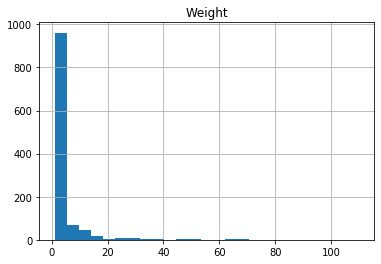

In [608]:
wap.hist('Weight', bins=25);

match 5 nodes that are connected through 2 neighbours and all conections are above 10

In [609]:
for el in execute(driver, 'MATCH (n)-[r1]->()-[r2]->()-[r3]->(m) WHERE r1.weight>10 AND r2.weight>10 AND r3.weight>10 AND n.name <> m.name RETURN DISTINCT n.name, m.name LIMIT 5'):
    print(el)
    print('__')

<Record n.name='NatashaRostova' m.name='Prince_Nikolay_Bolkonsky'>
__
<Record n.name='Princess_Mariya_Bolkonskaya' m.name='Prince_Nikolay_Bolkonsky'>
__
<Record n.name='Mikhail_Ilarionovich_Kutuzov' m.name='Prince_Nikolay_Bolkonsky'>
__
<Record n.name='Pierre_Bezukhov' m.name='Prince_Nikolay_Bolkonsky'>
__
<Record n.name='Bilibin' m.name='Prince_Nikolay_Bolkonsky'>
__
